# 4 Setting the initial SoC

Setting the initial SoC for your pack is performed with an argument passed to the solve algorithm. Currently the same value is applied to each battery but in future it will be possible to vary the SoC across the pack.

In [1]:
import liionpack as lp
import pybamm
import numpy as np
import matplotlib.pyplot as plt

c:\users\tom\code\pybamm\pybamm\expression_tree\functions.py:204: RuntimeWarning: invalid value encountered in sign
  return self.function(*evaluated_children)


Lets set up the most simple pack possible with 1 battery and very low busbar resistance to compare to a pure PyBaMM simulation

In [58]:
netlist = lp.setup_circuit(Np=1, Ns=1, Rb=1.0e-8, Rc=1.0e-8, Ri=5e-2, V=4.0, I=1.0)

In [59]:
# Heat transfer coefficients
htc = np.ones(1) * 10
# PyBaMM parameters
chemistry = pybamm.parameter_sets.Chen2020
parameter_values = pybamm.ParameterValues(chemistry=chemistry)

In [60]:
# Cycling experiment
experiment = pybamm.Experiment(
    [
        (
            "Discharge at 1 A for 1000 s or until 3.3 V",
            "Rest for 1000 s",
            "Charge at 1 A for 1000 s or until 4.0 V",
            "Rest for 1000 s",
        )
    ]
    * 3, period="10 s"
)

In [61]:
SoC = 0.5

In [62]:
# Solve pack
output = lp.solve(netlist=netlist,
                  parameter_values=parameter_values,
                  experiment=experiment,
                  output_variables=output_variables,
                  htc=htc, initial_soc=SoC)

Solving Pack: 100%|███████████████████████████████████████████████████████████████| 1200/1200 [00:06<00:00, 189.00it/s]


Let's compare to the PyBaMM simulation

In [63]:
parameter_values = pybamm.ParameterValues(chemistry=chemistry)
parameter_values.update({"Total heat transfer coefficient [W.m-2.K-1]": 10.0})
sim = lp.create_simulation(parameter_values, experiment, make_inputs=False)

In [64]:
sol = sim.solve(initial_soc=SoC)

Text(0.5, 1.0, 'Single PyBaMM Simulation')

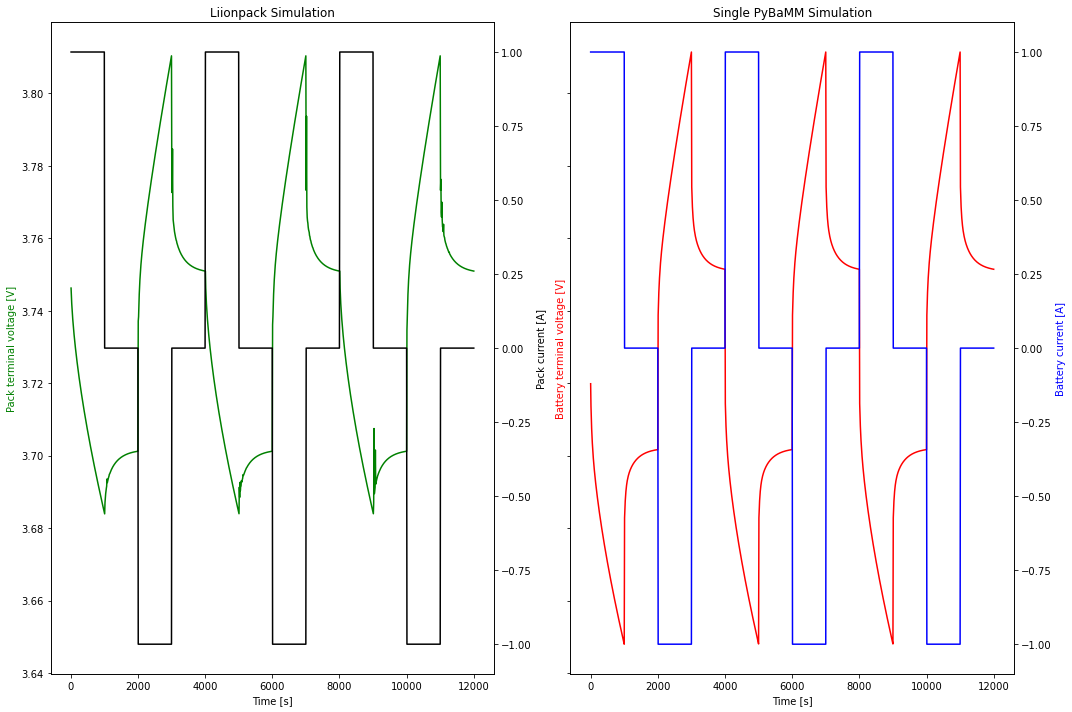

In [65]:
# Get pack level results
time = sol["Time [s]"].entries
v_pack = output["Pack terminal voltage [V]"]
i_pack = output["Pack current [A]"]
v_batt = sol["Terminal voltage [V]"].entries
i_batt = sol["Current [A]"].entries

# Plot pack voltage and current
_, (axl, axr) = plt.subplots(1, 2, tight_layout=True, figsize=(15, 10), sharex=True, sharey=True)
axl.plot(time[1:], v_pack, color="green", label="simulation")
axl.set_xlabel("Time [s]")
axl.set_ylabel("Pack terminal voltage [V]", color="green")
axl2 = axl.twinx()
axl2.plot(time[1:], i_pack, color="black", label="simulation")
axl2.set_ylabel("Pack current [A]", color="black")
axl2.set_title("Liionpack Simulation")
axr.plot(time, v_batt, color="red", label="simulation")
axr.set_xlabel("Time [s]")
axr.set_ylabel("Battery terminal voltage [V]", color="red")
axr2 = axr.twinx()
axr2.plot(time, i_batt, color="blue", label="simulation")
axr2.set_ylabel("Battery current [A]", color="blue")
axr2.set_title("Single PyBaMM Simulation")

In [53]:
output.keys()

dict_keys(['Time [s]', 'Pack current [A]', 'Pack terminal voltage [V]', 'Cell current [A]', 'Terminal voltage [V]', 'Measured battery open circuit voltage [V]', 'Local ECM resistance [Ohm]', 'X-averaged negative particle surface concentration [mol.m-3]', 'X-averaged positive particle surface concentration [mol.m-3]'])

In [56]:
output['Terminal voltage [V]'].min()

3.597551957691098

In [57]:
output['Pack terminal voltage [V]'].min()

3.6823172075752413